In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = np.round(cm,2).astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(f'{title}.jpg')
    plt.show()

In [4]:
path = Path(os.getcwd())/"data"
path

WindowsPath('D:/AI and ML/Recycle/Solution/data')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.366198,0.909870,0.276243,0.723757,01:21
1,1.021074,0.746026,0.240025,0.759975,01:15
2,0.897196,0.712865,0.247391,0.752609,01:16
3,0.902774,0.893408,0.295273,0.704727,01:16
4,0.932705,0.941684,0.290976,0.709024,01:16
5,0.884844,0.798385,0.281154,0.718846,01:16
6,0.865136,0.847479,0.295273,0.704727,01:16
7,0.806691,0.773638,0.283610,0.716390,01:16
8,0.755541,0.734542,0.259668,0.740331,01:16
9,0.707998,0.723899,0.252916,0.747084,01:16


Confusion Matrix


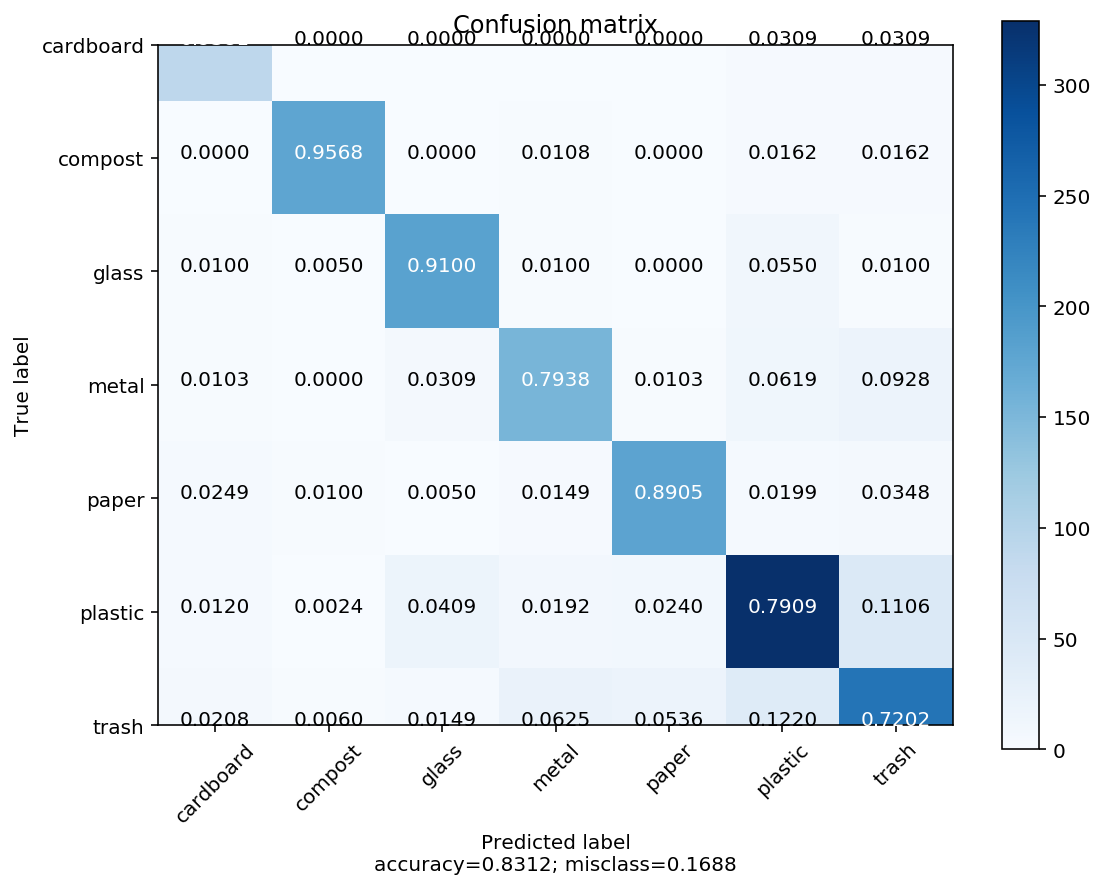

              precision    recall  f1-score   support

   cardboard       0.81      0.94      0.87        97
       glass       0.97      0.96      0.96       185
       metal       0.86      0.91      0.89       200
       paper       0.81      0.79      0.80       194
     plastic       0.86      0.89      0.87       201
       trash       0.82      0.79      0.80       416
     compost       0.75      0.72      0.74       336

    accuracy                           0.83      1629
   macro avg       0.84      0.86      0.85      1629
weighted avg       0.83      0.83      0.83      1629



NameError: name 'accuracy_score' is not defined

In [5]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=40,size=224)

learn = cnn_learner(data,models.resnet50,metrics=[error_rate,accuracy])
appropriate_lr = find_appropriate_lr(learn)
learn.fit_one_cycle(20,max_lr=appropriate_lr)

interp = ClassificationInterpretation.from_learner(learn)

print('Confusion Matrix')
cm = confusion_matrix(interp.pred_class, interp.y_true)
disp = plot_confusion_matrix(cm,target_names = ['cardboard','compost','glass','metal',
                                  'paper','plastic','trash'])
target_names = ['cardboard','glass','metal','paper','plastic','trash','compost']
print(classification_report(interp.pred_class, interp.y_true, target_names=target_names))
print ("Accuracy-",accuracy_score(interp.pred_class, interp.y_true))

learn.save('resnet50-fastai')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.379829,0.831267,0.266421,0.733579,01:52
1,0.966427,0.744044,0.247391,0.752609,01:50
2,0.868886,0.917498,0.300798,0.699202,01:52
3,0.939846,0.922626,0.303867,0.696133,01:51
4,0.993660,0.902542,0.318600,0.681400,01:50
5,0.948367,0.870393,0.295273,0.704727,01:50
6,0.931404,0.960627,0.318600,0.681400,01:50
7,0.838072,0.767677,0.268877,0.731123,01:50
8,0.782131,0.873315,0.322897,0.677103,01:51
9,0.739160,0.734580,0.268263,0.731737,01:50


Confusion Matrix


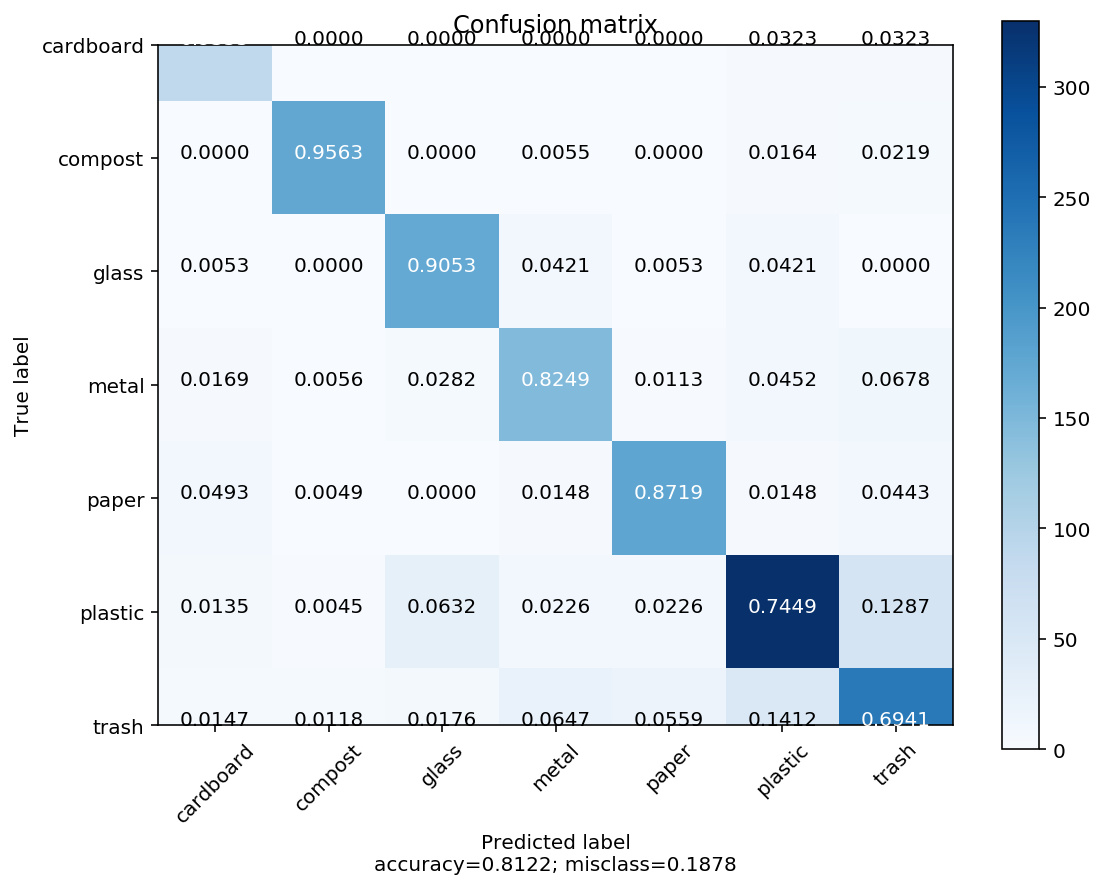

              precision    recall  f1-score   support

   cardboard       0.78      0.94      0.85        93
       glass       0.96      0.96      0.96       183
       metal       0.82      0.91      0.86       190
       paper       0.77      0.82      0.80       177
     plastic       0.85      0.87      0.86       203
       trash       0.82      0.74      0.78       443
     compost       0.74      0.69      0.71       340

    accuracy                           0.81      1629
   macro avg       0.82      0.85      0.83      1629
weighted avg       0.81      0.81      0.81      1629

Accuracy- 0.8121546961325967


In [7]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=40,size=224)

learn = cnn_learner(data,models.resnet101,metrics=[error_rate,accuracy])

appropriate_lr = find_appropriate_lr(learn)
learn.fit_one_cycle(20,max_lr=appropriate_lr)

interp = ClassificationInterpretation.from_learner(learn)

print('Confusion Matrix')
cm = confusion_matrix(interp.pred_class, interp.y_true)
disp = plot_confusion_matrix(cm,target_names = ['cardboard','compost','glass','metal',
                                  'paper','plastic','trash'])
target_names = ['cardboard','glass','metal','paper','plastic','trash','compost']
print(classification_report(interp.pred_class, interp.y_true, target_names=target_names))
print ("Accuracy-",accuracy_score(interp.pred_class, interp.y_true))

learn.save('resnet101-fastai')

In [7]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=20,size=224)

learn = cnn_learner(data,models.resnet152,metrics=[error_rate,accuracy])

appropriate_lr = find_appropriate_lr(learn)
learn.fit_one_cycle(20,max_lr=appropriate_lr)

interp = ClassificationInterpretation.from_learner(learn)

print('Confusion Matrix')
cm = confusion_matrix(interp.pred_class, interp.y_true)
disp = plot_confusion_matrix(cm,target_names = ['cardboard','compost','glass','metal',
                                  'paper','plastic','trash'])
target_names = ['cardboard','glass','metal','paper','plastic','trash','compost']
print(classification_report(interp.pred_class, interp.y_true, target_names=target_names))
print ("Accuracy-",accuracy_score(interp.pred_class, interp.y_true))

learn.save('resnet152-fastai')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.213728,0.956639,0.280540,0.719460,03:00
1,1.081594,0.952753,0.322897,0.677103,02:54
2,1.320489,1.340838,0.453039,0.546961,02:54
3,1.313599,1.318284,0.469613,0.530387,02:54
4,1.221846,1.142150,0.398404,0.601596,02:54
5,1.195095,1.373319,0.483732,0.516268,02:54


KeyboardInterrupt: 

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.651945,0.523392,0.196440,0.803560,02:33
1,0.852570,0.941962,0.321056,0.678944,02:31
2,0.957638,1.027158,0.361572,0.638429,02:30
3,0.998275,0.958612,0.357274,0.642726,02:31
4,0.889787,0.916215,0.330878,0.669122,02:31
5,0.773904,0.766461,0.275629,0.724371,02:31
6,0.683214,0.652219,0.242480,0.757520,02:30
7,0.579604,0.571677,0.204420,0.795580,02:30
8,0.569445,0.531373,0.193370,0.806630,02:31
9,0.488890,0.523158,0.189073,0.810927,02:30


Confusion Matrix


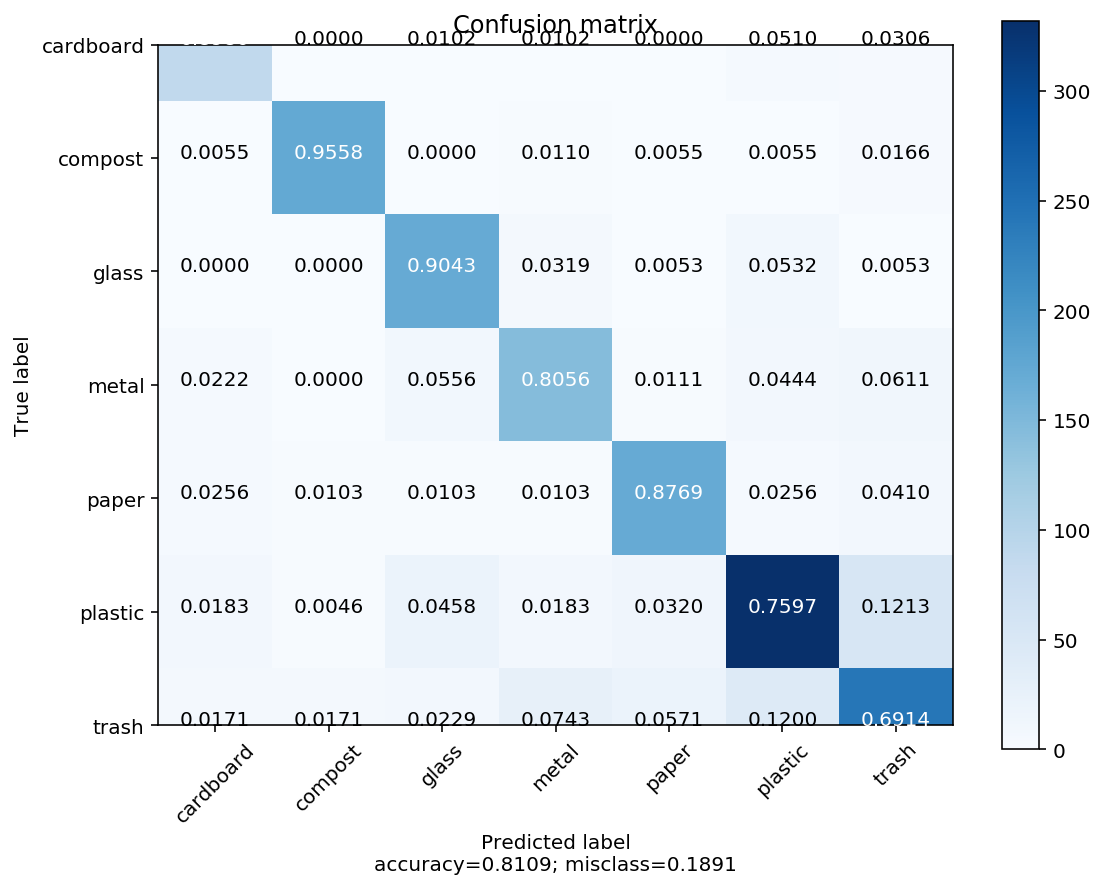

              precision    recall  f1-score   support

   cardboard       0.79      0.90      0.84        98
       glass       0.95      0.96      0.95       181
       metal       0.81      0.90      0.85       188
       paper       0.76      0.81      0.78       180
     plastic       0.82      0.88      0.85       195
       trash       0.82      0.76      0.79       437
     compost       0.75      0.69      0.72       350

    accuracy                           0.81      1629
   macro avg       0.81      0.84      0.83      1629
weighted avg       0.81      0.81      0.81      1629

Accuracy- 0.810926949048496


In [8]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=32,size=224)

learn = cnn_learner(data,models.resnet152,metrics=[error_rate,accuracy])
learn.load('model-resnext101')

appropriate_lr = find_appropriate_lr(learn)
learn.fit_one_cycle(10,max_lr=appropriate_lr)

interp = ClassificationInterpretation.from_learner(learn)
print('Confusion Matrix')
cm = confusion_matrix(interp.pred_class, interp.y_true)
disp = plot_confusion_matrix(cm,target_names = ['cardboard','compost','glass','metal',
                                  'paper','plastic','trash'])
target_names = ['cardboard','glass','metal','paper','plastic','trash','compost']
print(classification_report(interp.pred_class, interp.y_true, target_names=target_names))
print ("Accuracy-",accuracy_score(interp.pred_class, interp.y_true))

learn.save('resnex101-fastai')

In [9]:
appropriate_lr = find_appropriate_lr(learn)
learn.fit_one_cycle(5,max_lr=appropriate_lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.618177,0.842669,0.284223,0.715777,02:30
1,0.815197,0.789355,0.286679,0.713321,02:31
2,0.766457,0.642153,0.233886,0.766114,02:30
3,0.599151,0.569538,0.214242,0.785758,02:30
4,0.493348,0.539238,0.198895,0.801105,02:30
